# Hash Articles
- Author: Yuege Xie (EID:yx4256)
- Python version: Python 3
- The file should be stored in the same file folder of the data.

In [7]:
#=====import packages=====#
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import *
import binascii
import time
from itertools import combinations 
%matplotlib inline
np.random.seed(1023)

# check the python version
from platform import python_version
print("Current python version is {}".format(python_version()))

Current python version is 3.6.7


In [8]:
#=====4(a) read data, get shingle set and shingles for each article=====#

# initialization
shingles_dic = {}
shingles_set = set()
id_list = []
total = 0
num = 1000
stop_words = stopwords.words("english")

# open file
file = open("articles-1000.txt","r") 

# split, remove stop words and get shingles
for i in range(num):
    
    article = file.readline() 
    article = article.split()
    shingles_doc = set()
    
    # save id and delete id in the list
    doc_id = article[0]
    id_list.append(doc_id)
    del article[0]
    
    # remove stopwords
    article = list(filter(lambda w: w not in stop_words, article))
    
    for j in range(len(article)-1):
        
        shingle = article[j] + " " + article[j+1]
        
        # Hash the shingle to a 32-bit integer, note that it is different from Python 2
        shingleID = binascii.crc32(shingle.encode('utf8'))
        shingles_doc.add(shingleID)
        
    # save single in dictionary 
    shingles_set.update(shingles_doc)
    shingles_dic[doc_id] = shingles_doc
    total = total + len(article)-1
    
# close file
file.close() 
unique = len(shingles_set)
print("=====4(a) stats of the dataset=====\n")
print("Total number of unique singles is {} and average is {} per book."
      .format(unique, total/num))

=====4(a) stats of the dataset=====

Total number of unique singles is 131266 and average is 168.694 per book.


In [9]:
def jaccard_sim(i, j):
    union = len(shingles_dic[id_list[i]] | shingles_dic[id_list[j]])
    inter = len(shingles_dic[id_list[i]] & shingles_dic[id_list[j]])
    return inter/union

In [10]:
def generate_sig(n, n_hash):
    
    p = 4294967311
    signatures_mat = np.zeros((n, n_hash), dtype=int)
    c1 = np.random.randint(low=1,high=p,size=n_hash) 
    c2 = np.random.randint(low=1,high=p,size=n_hash)
    
    for j in range(n):
    
        signature = []
        for i in range(n_hash):
            hash_ = (c1[i] * np.array(list(shingles_dic[id_list[j]])) + c2[i]) % p
        
            signature.append(min(hash_))
    
        signatures_mat[j,:] = np.array(signature)
    
    return signatures_mat

In [11]:
#=====4(b) generate MinHash signatures using 10 hash functions=====#

# set parameters
# use max_p to represent infinity since the result will not be bigger than p+1
# max_p = p+1
num_hash = 10
signatures_mat = generate_sig(num, num_hash)

# find similar book of 1st book
est_Jac_1st = np.zeros(num)

for i in range(1, num):
    est_Jac_1st[i] = np.sum(signatures_mat[0,:] 
                            == signatures_mat[i,:])/num_hash

idx = np.argmax(est_Jac_1st)

print("=====4(b) result of similar book of 1st book=====\n")
print('The triplet (bookID = {}, estimatedJaccard = {}, trueJaccard = {})'
      .format(id_list[idx], est_Jac_1st[idx], jaccard_sim(0,idx)))

=====4(b) result of similar book of 1st book=====

The triplet (bookID = t7998, estimatedJaccard = 1.0, trueJaccard = 1.0)


In [12]:
def get_set(b, r, num=1000):
    # initialize and generate signature matrix
    n = b*r
    sig_mat = generate_sig(num, n)
    S = set()
    
    for j in range(1, num):
        for i in range(b):
            if list(sig_mat[0, i*r:(i+1)*r]) == list(sig_mat[j, i*r:(i+1)*r]):
                S.add(j)
                break
                
    print('b={}, r={}, S={}'.format(b, r, S))
    return S

In [7]:
def false_pos(S):
    t = 0.8
    count = 0
    
    for i in S:
        if jaccard_sim(i, 0) < t:
            count = count + 1
           
    return count/len(S)

In [8]:
def amplification(b_val, r_val):
    amp = []
    for b in b_val:
        for r in r_val:
            
            fp = 0 
            for k in range(10):
                S = get_set(b,r)
                fp = fp + false_pos(S)
            amp.append(fp/10)
            
    return amp

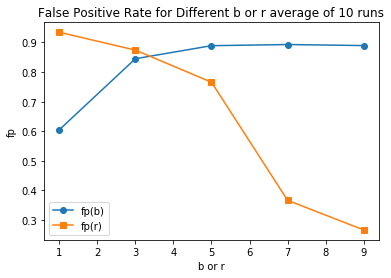

In [9]:
#=====4(c) amplification=====#
plt.clf()
plt.title('False Positive Rate for Different b or r average of 10 runs')
plt.xlabel('b or r')
plt.ylabel('fp')

# plot fp as a function of b
b_val = [1,3,5,7,9]
amp_b = amplification(b_val, [2])
plt.plot(b_val, amp_b, label = "fp(b)", marker = 'o')

# plot fp as a function of r
r_val = [1,3,5,7,9]
amp_r = amplification([10], r_val)
plt.plot(r_val, amp_r, label = 'fp(r)', marker = 's')

plt.legend(loc=0)
plt.savefig('pc4.pdf') 
plt.show()

In [10]:
def print_top20(Jac_, pair, top20_idx, print_id=True):
    
    print("=====result of top 20 similar document pairs without approximation=====\n")

    for i in range(min(20, len(Jac_))):
        if print_id == True:     
            print((id_list[pair[top20_idx[i]][0]], id_list[pair[top20_idx[i]][1]], Jac_[top20_idx[i]]))
        else:
            print((pair[top20_idx[i]][0], pair[top20_idx[i]][1], Jac_[top20_idx[i]]))
    print("\n")

In [11]:
#=====4(d)(i) find twenty most similar article pairs without approximation=====#
print("=====4(d)(i) running calculating Jaccard without approximation=====\n")

time0 = time.time()

# initialization
count = int(num*(num-1)/2)
Jac_ = []
pair = []

# get true jaccard similary for each pair
for i in range(num):
    for j in range(i+1, num):
        pair.append((i,j))
        Jac_.append(jaccard_sim(i,j))

assert len(pair)==count

# sort top20 of Jaccard score 
top20_idx = np.argsort(-np.array(Jac_))

# print results
print('=====Total running time without approximation: {} seconds=====\n'
      .format(time.time() - time0))

# if print_id is true, print id pair; else print index pair
print_top20(Jac_, pair, top20_idx, print_id=True)
del Jac_, pair

=====4(d)(i) running calculating Jaccard without approximation=====

=====Total running time without approximation: 6.021335124969482 seconds=====

=====result of top 20 similar document pairs without approximation=====

('t120', 't7998', 1.0)
('t2957', 't7111', 1.0)
('t1297', 't4638', 0.9833333333333333)
('t3466', 't7563', 0.9831460674157303)
('t2839', 't9303', 0.9827586206896551)
('t2535', 't8642', 0.9822485207100592)
('t1088', 't5015', 0.9821428571428571)
('t1768', 't5248', 0.9817073170731707)
('t980', 't2023', 0.9810126582278481)
('t1952', 't3495', 0.9805194805194806)
('t311', 't7998', 0.5705128205128205)
('t120', 't311', 0.5705128205128205)
('t945', 't7998', 0.536144578313253)
('t120', 't945', 0.536144578313253)
('t120', 't576', 0.5313432835820896)
('t576', 't7998', 0.5313432835820896)
('t6601', 't7998', 0.5281899109792285)
('t120', 't6601', 0.5281899109792285)
('t120', 't966', 0.5266272189349113)
('t966', 't7998', 0.5266272189349113)




In [12]:
def lsh(b, r):
    
    time0 = time.time()
    n = b*r
    sig_mat = generate_sig(num, n)
    candidates = set()
    Jac_ = []

    for i in range(b):
        bucket = {}
        
        for j in range(num):
            skey = np.array2string(sig_mat[j, i*r:(i+1)*r])
            if skey in bucket.keys():
                bucket[skey].append(j)
            else:
                bucket[skey] = [j]
    
        for key in bucket.keys():
            if len(bucket[key]) > 1:
                comb = list(combinations(bucket[key], 2))
                candidates.update(comb)

    pair = list(candidates)

    for c in pair:
        Jac_.append(jaccard_sim(c[0],c[1]))
       
    top20_idx = np.argsort(-np.array(Jac_))    
    
    # print results
    print('=====Total running time with approximation with b={} and r={}: {} seconds=====\n'
          .format(b, r, time.time() - time0))
    
    # if print_id is true, print id pair; else print index pair
    print_top20(Jac_, pair, top20_idx, print_id=True)

In [13]:
#=====4(d)(ii) find twenty most similar article pairs using LSH=====#
print("=====4(d)(ii) running LSH approximation=====\n")

b_val = [1,3,5,7,9,10]
r_val = [1,2,3,5,7,9]

for b in b_val:
    for r in r_val:
        lsh(b=b, r=r)

=====4(d)(ii) running LSH approximation=====

=====Total running time with approximation with b=1 and r=1: 0.08072710037231445 seconds=====

=====result of top 20 similar document pairs without approximation=====

('t2957', 't7111', 1.0)
('t120', 't7998', 1.0)
('t1297', 't4638', 0.9833333333333333)
('t3466', 't7563', 0.9831460674157303)
('t2839', 't9303', 0.9827586206896551)
('t2535', 't8642', 0.9822485207100592)
('t1088', 't5015', 0.9821428571428571)
('t1768', 't5248', 0.9817073170731707)
('t980', 't2023', 0.9810126582278481)
('t1952', 't3495', 0.9805194805194806)
('t311', 't7998', 0.5705128205128205)
('t120', 't311', 0.5705128205128205)
('t120', 't945', 0.536144578313253)
('t945', 't7998', 0.536144578313253)
('t576', 't7998', 0.5313432835820896)
('t120', 't576', 0.5313432835820896)
('t120', 't6601', 0.5281899109792285)
('t6601', 't7998', 0.5281899109792285)
('t966', 't7998', 0.5266272189349113)
('t120', 't966', 0.5266272189349113)


=====Total running time with approximation with b=1

=====Total running time with approximation with b=5 and r=1: 0.4260737895965576 seconds=====

=====result of top 20 similar document pairs without approximation=====

('t2957', 't7111', 1.0)
('t120', 't7998', 1.0)
('t1297', 't4638', 0.9833333333333333)
('t3466', 't7563', 0.9831460674157303)
('t2839', 't9303', 0.9827586206896551)
('t2535', 't8642', 0.9822485207100592)
('t1088', 't5015', 0.9821428571428571)
('t1768', 't5248', 0.9817073170731707)
('t980', 't2023', 0.9810126582278481)
('t1952', 't3495', 0.9805194805194806)
('t311', 't7998', 0.5705128205128205)
('t120', 't311', 0.5705128205128205)
('t120', 't945', 0.536144578313253)
('t945', 't7998', 0.536144578313253)
('t576', 't7998', 0.5313432835820896)
('t120', 't576', 0.5313432835820896)
('t120', 't6601', 0.5281899109792285)
('t6601', 't7998', 0.5281899109792285)
('t120', 't966', 0.5266272189349113)
('t966', 't7998', 0.5266272189349113)


=====Total running time with approximation with b=5 and r=2: 0.4830811023712158 seconds=====

====

=====Total running time with approximation with b=7 and r=9: 2.1872479915618896 seconds=====

=====result of top 20 similar document pairs without approximation=====

('t2957', 't7111', 1.0)
('t120', 't7998', 1.0)
('t1297', 't4638', 0.9833333333333333)
('t3466', 't7563', 0.9831460674157303)
('t2839', 't9303', 0.9827586206896551)
('t2535', 't8642', 0.9822485207100592)
('t1088', 't5015', 0.9821428571428571)
('t1768', 't5248', 0.9817073170731707)
('t980', 't2023', 0.9810126582278481)
('t1952', 't3495', 0.9805194805194806)


=====Total running time with approximation with b=9 and r=1: 0.749251127243042 seconds=====

=====result of top 20 similar document pairs without approximation=====

('t120', 't7998', 1.0)
('t2957', 't7111', 1.0)
('t1297', 't4638', 0.9833333333333333)
('t3466', 't7563', 0.9831460674157303)
('t2839', 't9303', 0.9827586206896551)
('t2535', 't8642', 0.9822485207100592)
('t1088', 't5015', 0.9821428571428571)
('t1768', 't5248', 0.9817073170731707)
('t980', 't2023', 0.981012

=====Total running time with approximation with b=10 and r=7: 2.564901113510132 seconds=====

=====result of top 20 similar document pairs without approximation=====

('t2957', 't7111', 1.0)
('t120', 't7998', 1.0)
('t1297', 't4638', 0.9833333333333333)
('t3466', 't7563', 0.9831460674157303)
('t2839', 't9303', 0.9827586206896551)
('t2535', 't8642', 0.9822485207100592)
('t1088', 't5015', 0.9821428571428571)
('t1768', 't5248', 0.9817073170731707)
('t980', 't2023', 0.9810126582278481)
('t1952', 't3495', 0.9805194805194806)
('t120', 't576', 0.5313432835820896)
('t576', 't7998', 0.5313432835820896)


=====Total running time with approximation with b=10 and r=9: 3.1154239177703857 seconds=====

=====result of top 20 similar document pairs without approximation=====

('t2957', 't7111', 1.0)
('t120', 't7998', 1.0)
('t1297', 't4638', 0.9833333333333333)
('t3466', 't7563', 0.9831460674157303)
('t2839', 't9303', 0.9827586206896551)
('t2535', 't8642', 0.9822485207100592)
('t1088', 't5015', 0.982142